# IMPORT LIBRARIES

In [160]:
import pandas as pd
import numpy as np

import seaborn as sns

import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

# READING DATA FROM SOURCE

In [2]:
dfCustomers = pd.read_csv("customers.csv", delimiter = ",")
dfCustomers.set_index("CLIENT_ID", inplace = True)

In [3]:
dfCustomers.head()

,ACCOUNT_ID,GENDER,BIRTH_DT,ACTIVE,LOAN,DISTRICT_ID,SET_SPLIT
CLIENT_ID,,,,,,,
1,1,F,19701213,1,0.0,18,TRAIN
2,2,M,19450204,1,1.0,1,TRAIN
4,3,M,19561201,1,0.0,5,TEST
7,5,M,19290125,1,0.0,15,TRAIN
8,6,F,19380221,1,0.0,51,TRAIN


In [4]:
dfTransactions = pd.read_csv("transactions.csv", delimiter = ",")
dfTransactions.set_index("TRANS_ID", inplace = True)

In [5]:
dfTransactions.head()

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
695247,2378.0,1011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
171812,576.0,1011993,900.0,900.0,CREDIT,CREDIT_IN_CASH
207264,704.0,1011993,1000.0,1000.0,CREDIT,CREDIT_IN_CASH
1117247,3818.0,1011993,600.0,600.0,CREDIT,CREDIT_IN_CASH
579373,1972.0,2011993,400.0,400.0,CREDIT,CREDIT_IN_CASH


In [6]:
dfDistricts =  pd.read_csv("districts.csv", delimiter = ",")
dfDistricts.set_index("DISTRICT_ID", inplace = True)

In [7]:
dfDistricts.head()

,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
DISTRICT_ID,,,,,,,,,
1,1204953,1,100.0,12541,0.29,0.43,167,85677,99107
2,88884,5,46.7,8507,1.67,1.85,132,2159,2674
3,75232,5,41.7,8980,1.95,2.21,111,2824,2813
4,149893,6,67.4,9753,4.64,5.05,109,5244,5892
5,95616,6,51.4,9307,3.85,4.43,118,2616,3040


# DATA EXPLORATION

## Exploring Uniqueness

### dfCustomers

In [8]:
len(dfCustomers.index.unique()) == len(dfCustomers.index)

True

### dfDistricts

In [9]:
len(dfDistricts.index.unique()) == len(dfDistricts.index)

True

### dfTransactions

dfTransactions contain some duplicated TRANS_IDs.

In [10]:
len(dfTransactions.index.unique()) == len(dfTransactions.index)

False

There are 20000 rows which are duplicated.

In [11]:
dfTransactions[dfTransactions.index.duplicated(keep=False)]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
612405,2087.0,29011993,16983.0,17583.0,CREDIT,CREDIT_IN_CASH
612405,2087.0,29011993,16983.0,17583.0,CREDIT,CREDIT_IN_CASH
796773,2714.0,30011993,800.0,800.0,CREDIT,CREDIT_IN_CASH
796773,2714.0,30011993,800.0,800.0,CREDIT,CREDIT_IN_CASH
542217,1844.0,7021993,3242.0,6996.6,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...
3637054,3225.0,31121998,359.2,85171.9,CREDIT,NaN
3553434,696.0,31121998,234.8,56102.8,CREDIT,NaN
3471092,4526.0,31121998,281.5,83037.3,CREDIT,NaN


In [12]:
dfTransactions.loc[3457056]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
3457056,9707.0,31121998,272.0,99872.3,CREDIT,NaN
3457056,9707.0,31121998,272.0,99872.3,CREDIT,NaN


## Exploring Data Types

### dfCustomers

"LOAN" field should be either 1 or 0 by description. Usually such fields have integer data types. However, it looks as float64, it s a sign that this field can include some unexpected data.

In [13]:
dfCustomers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450 entries, 1 to 13998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ACCOUNT_ID   4450 non-null   int64  
 1   GENDER       4450 non-null   object 
 2   BIRTH_DT     4450 non-null   int64  
 3   ACTIVE       4450 non-null   int64  
 4   LOAN         4400 non-null   float64
 5   DISTRICT_ID  4450 non-null   int64  
 6   SET_SPLIT    4450 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 407.2+ KB


Confirming that each client has only 1 account id in dfCustomers dataset.

In [14]:
len(dfCustomers.index.unique()) == len(dfCustomers["ACCOUNT_ID"].unique())

True

### dfDistricts

"UNEMP_95" and "CRIME_95" fields look as object data type. By description of field, "UNEMP_95" should represent unemployment ratio which is float, however it looks as object. Similarly, "CRIME_95" field represents number of committed crimes which should be in integer type. However, it also looks as object. These are signs that, the fields of "UNEMP_95" and "CRIME_95" contain some unexpected data.

In [15]:
dfDistricts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_INHAB      77 non-null     int64  
 1   N_CITIES     77 non-null     int64  
 2   URBAN_RATIO  77 non-null     float64
 3   AVG_SALARY   77 non-null     int64  
 4   UNEMP_95     77 non-null     object 
 5   UNEMP_96     77 non-null     float64
 6   N_ENTR       77 non-null     int64  
 7   CRIME_95     77 non-null     object 
 8   CRIME_96     77 non-null     int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 8.1+ KB


### dfTransactions

"ACCOUNT_ID" field's data type should be integer.

In [16]:
dfTransactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1066320 entries, 695247 to 3624981
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ACCOUNT_ID  1061320 non-null  float64
 1   DATE        1066320 non-null  int64  
 2   AMOUNT      1066320 non-null  float64
 3   BALANCE     1066320 non-null  float64
 4   TYPE        1066320 non-null  object 
 5   OPERATION   881436 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 89.2+ MB


## Exploring Missing Data

### dfCustomers

Only field 'LOAN' includes NaN values in dfCustomers dataframe.

In [17]:
dfCustomers.columns[dfCustomers.isna().any()].tolist()

['LOAN']

Checking unique fields to be sure if any other missing values except NaN. Unique values are sorted to detect missing values on the boundaries of the sorted array.

In [18]:
np.sort(dfCustomers.index.unique())

array([    1,     2,     4, ..., 13968, 13971, 13998], dtype=int64)

In [19]:
np.sort(dfCustomers["ACCOUNT_ID"].unique())

array([    1,     2,     3, ..., 11359, 11362, 11382], dtype=int64)

In [20]:
np.sort(dfCustomers["GENDER"].unique())

array(['F', 'M'], dtype=object)

In [21]:
np.sort(dfCustomers["BIRTH_DT"].unique())

array([19180107, 19180111, 19180116, ..., 19821005, 19821020, 19821211],
      dtype=int64)

Confirming that each date value includes 8 characters.

In [22]:
dfCustomers["BIRTH_DT"].astype(str).str.len().unique()

array([8], dtype=int64)

In [23]:
np.sort(dfCustomers["ACTIVE"].unique())

array([1], dtype=int64)

In [24]:
np.sort(dfCustomers["LOAN"].unique())

array([ 0.,  1., nan])

In [25]:
np.sort(dfCustomers["DISTRICT_ID"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77], dtype=int64)

In [26]:
np.sort(dfCustomers["SET_SPLIT"].unique())

array(['TEST', 'TRAIN'], dtype=object)

### dfDistricts

Looks like there is no field that contains NaN value in dfDistricts.

In [27]:
dfDistricts.columns[dfDistricts.isna().any()].tolist()

[]

Checking unique fields to be sure if any other missing values except NaN. Unique values are sorted to detect missing values on the boundaries of the sorted array.

In [28]:
np.sort(dfDistricts.index.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77], dtype=int64)

In [29]:
np.sort(dfDistricts["N_INHAB"].unique())

array([  42821,   45714,   51313,   51428,   53921,   58400,   58796,
         67298,   70646,   70699,   72541,   74062,   75232,   75637,
         75685,   77917,   77963,   78955,   81344,   85852,   86513,
         87419,   88757,   88768,   88884,   92084,   93931,   94725,
         94812,   95616,   95907,  102609,  103347,  105058,  105606,
        106054,  107870,  107911,  108871,  109164,  110643,  112065,
        112709,  114006,  114200,  117897,  118650,  119895,  121947,
        122603,  124605,  125236,  125832,  127369,  128118,  133777,
        138032,  139012,  145688,  148545,  149893,  157042,  159617,
        161227,  161854,  161954,  162580,  170449,  177686,  182027,
        197099,  226122,  228848,  285387,  323870,  387570, 1204953],
      dtype=int64)

In [30]:
np.sort(dfDistricts["N_CITIES"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [31]:
np.sort(dfDistricts["URBAN_RATIO"].unique())

array([ 33.9,  36.5,  36.9,  40.7,  41.3,  41.7,  43.7,  43.8,  46. ,
        46.7,  48. ,  48.3,  48.4,  50.5,  50.9,  51.2,  51.4,  51.5,
        51.9,  52. ,  52.4,  52.7,  53. ,  53.5,  53.8,  55.3,  55.6,
        56.4,  56.9,  57.2,  58. ,  58.4,  59. ,  59.1,  59.2,  59.8,
        60.8,  61.4,  61.7,  61.9,  62.1,  62.3,  62.6,  63.1,  63.4,
        63.6,  64.6,  65.3,  67. ,  67.4,  69.4,  69.7,  70.5,  72.8,
        73.5,  74.7,  74.8,  76.3,  80. ,  80.5,  81. ,  81.8,  84.7,
        85.2,  85.3,  85.5,  85.6,  87.7,  89.9, 100. ])

In [32]:
np.sort(dfDistricts["AVG_SALARY"].unique())

array([ 8110,  8114,  8173,  8187,  8208,  8240,  8254,  8288,  8363,
        8369,  8388,  8390,  8402,  8403,  8427,  8441,  8444,  8507,
        8512,  8541,  8544,  8546,  8547,  8554,  8561,  8594,  8598,
        8620,  8624,  8678,  8705,  8720,  8743,  8746,  8754,  8757,
        8772,  8814,  8819,  8843,  8867,  8899,  8909,  8930,  8965,
        8968,  8980,  8991,  8994,  9045,  9060,  9065,  9104,  9198,
        9272,  9307,  9317,  9425,  9538,  9622,  9624,  9650,  9675,
        9753,  9832,  9893,  9897,  9920, 10045, 10124, 10177, 10446,
       10673, 10787, 11277, 12541], dtype=int64)

"UNEMP_95" field contains value of question mark character '?'.

In [33]:
np.sort(dfDistricts["UNEMP_95"].unique())

array(['0.29', '0.45', '0.56', '0.65', '1.02', '1.10', '1.12', '1.25',
       '1.29', '1.39', '1.42', '1.51', '1.60', '1.62', '1.67', '1.72',
       '1.78', '1.79', '1.88', '1.89', '1.95', '2.26', '2.28', '2.38',
       '2.41', '2.47', '2.51', '2.52', '2.53', '2.64', '2.65', '2.77',
       '2.79', '2.80', '2.82', '2.83', '2.95', '3.13', '3.24', '3.32',
       '3.33', '3.38', '3.39', '3.45', '3.51', '3.52', '3.73', '3.79',
       '3.80', '3.83', '3.85', '4.01', '4.09', '4.46', '4.64', '4.69',
       '4.73', '4.75', '4.76', '4.83', '5.38', '5.74', '5.75', '5.77',
       '5.93', '6.43', '6.49', '6.63', '7.08', '7.34', '?'], dtype=object)

In [34]:
np.sort(dfDistricts["UNEMP_96"].unique())

array([0.43, 0.54, 0.59, 1.21, 1.25, 1.29, 1.44, 1.54, 1.71, 1.81, 1.85,
       1.86, 1.96, 2.01, 2.07, 2.21, 2.26, 2.31, 2.43, 2.44, 2.5 , 2.62,
       2.66, 2.68, 2.87, 2.89, 2.94, 2.97, 3.09, 3.22, 3.26, 3.35, 3.47,
       3.49, 3.56, 3.6 , 3.64, 3.67, 3.74, 3.76, 3.95, 3.97, 3.98, 4.02,
       4.12, 4.2 , 4.28, 4.31, 4.43, 4.48, 4.5 , 4.52, 4.72, 4.79, 4.98,
       5.05, 5.39, 5.44, 5.45, 5.56, 5.57, 5.66, 5.72, 5.74, 5.88, 6.55,
       7.01, 7.07, 7.61, 7.68, 7.75, 8.23, 9.4 ])

In [35]:
np.sort(dfDistricts["N_ENTR"].unique())

array([ 81,  87,  90,  94,  96,  97,  99, 100, 102, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       123, 124, 125, 126, 127, 128, 130, 131, 132, 135, 137, 140, 141,
       145, 149, 154, 155, 167], dtype=int64)

"CRIME_95" field contains value of question mark character '?'.

In [36]:
np.sort(dfDistricts["CRIME_95"].unique())

array(['1003', '1029', '1089', '1328', '1562', '1563', '1580', '1597',
       '1655', '1658', '1660', '1740', '1822', '1845', '1850', '18721',
       '1874', '18782', '1879', '2080', '2112', '2123', '2157', '2159',
       '2166', '2212', '2247', '2299', '2564', '2595', '2616', '2640',
       '2653', '2719', '2824', '2854', '2879', '2985', '2987', '3244',
       '3384', '3460', '3475', '3496', '3659', '3729', '3736', '3804',
       '3810', '4063', '4085', '4147', '4289', '4340', '4355', '4484',
       '4650', '4947', '4980', '5179', '5198', '5244', '5323', '5623',
       '5796', '6041', '6079', '6445', '6604', '6949', '818', '85677',
       '9672', '9878', '999', '?'], dtype=object)

In [37]:
np.sort(dfDistricts["CRIME_96"].unique())

array([  888,  1099,  1117,  1127,  1181,  1358,  1452,  1460,  1525,
        1542,  1668,  1717,  1875,  1879,  1903,  1910,  1913,  2059,
        2103,  2122,  2123,  2134,  2218,  2252,  2305,  2325,  2354,
        2471,  2487,  2618,  2674,  2718,  2799,  2804,  2807,  2813,
        2822,  2906,  3040,  3079,  3120,  3158,  3198,  3529,  3590,
        3620,  3651,  3839,  3868,  3891,  3894,  4166,  4265,  4316,
        4433,  4505,  4595,  4743,  4846,  4859,  4987,  5190,  5273,
        5410,  5471,  5887,  5892,  6132,  6261,  6295,  6872,  9208,
       10108, 18347, 18696, 99107], dtype=int64)

### dfTransactions

"ACCOUNT_ID" and "OPERATION" operation fields contain NaN values.

In [38]:
dfTransactions.columns[dfTransactions.isna().any()].tolist()

['ACCOUNT_ID', 'OPERATION']

In [39]:
np.sort(dfTransactions.index.unique())

array([      1,       5,       6, ..., 3682985, 3682986, 3682987],
      dtype=int64)

"ACCOUNT_ID" field contains NaN values.

In [40]:
np.sort(dfTransactions["ACCOUNT_ID"].unique())

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 1.1362e+04, 1.1382e+04,
              nan])

"DATE" field doesn't contain NaN value but date format is not in DDMMYYY format for some values.

In [41]:
np.sort(dfTransactions["DATE"].unique())

array([ 1011993,  1011994,  1011995, ..., 31121996, 31121997, 31121998],
      dtype=int64)

Ther are incompatible formats of DD such as 40, 50, 41 etc. 

In [42]:
 dfTransactions["DATE"].astype(str).str[:2].unique()

array(['10', '20', '30', '40', '50', '60', '70', '80', '90', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '31', '41', '51', '61', '71', '81',
       '91'], dtype=object)

Ther are incompatible formats of MM such as 71, 81, 91 etc.

In [43]:
dfTransactions["DATE"].astype(str).str[2:4].unique()

array(['11', '01', '21', '02', '31', '03', '41', '04', '51', '05', '61',
       '06', '71', '07', '81', '08', '91', '09', '10', '12'], dtype=object)

When some accounts are checked, it is observed that they are not inserted as DDMMYYY but DDMMYYYY format. And when day of month is less than 10, they are inserted only 1 digit not 2 digits.

In [44]:
 dfTransactions[dfTransactions["DATE"].astype(str).str[:2] == "50"]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
192096,652.0,5011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
232961,793.0,5011993,3401.0,4201.0,CREDIT,COLLECTION_FROM_OTHER_BANK
637742,2177.0,5011993,5123.0,5923.0,CREDIT,COLLECTION_FROM_OTHER_BANK
2908688,9635.0,5011993,400.0,400.0,CREDIT,CREDIT_IN_CASH
224344,764.0,5021993,6238.0,7338.0,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...
3149369,10451.0,5091998,689.0,14496.7,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK
3147256,10445.0,5091998,23910.0,89535.6,CREDIT,CREDIT_IN_CASH
3145327,10439.0,5091998,10134.0,61170.3,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK


In [45]:
dfTransactions[dfTransactions["ACCOUNT_ID"] == 652]

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
192096,652.0,5011993,700.0,700.0,CREDIT,CREDIT_IN_CASH
192097,652.0,9011993,13851.0,14551.0,CREDIT,CREDIT_IN_CASH
3552056,652.0,31011993,45.0,14596.0,CREDIT,NaN
192366,652.0,4021993,2900.0,17496.0,CREDIT,CREDIT_IN_CASH
192098,652.0,9021993,13851.0,31347.0,CREDIT,CREDIT_IN_CASH
...,...,...,...,...,...,...
192437,652.0,5121998,4200.0,56431.3,WITHDRAWAL,WITHDRAWAL_IN_CASH
192168,652.0,9121998,20776.0,77207.3,CREDIT,CREDIT_IN_CASH
192240,652.0,11121998,7591.0,69616.3,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK


In [46]:
dfTransactions["DATE"].astype(str).str[4:].unique()

array(['993', '1993', '994', '1994', '995', '1995', '996', '1996', '997',
       '1997', '998', '1998'], dtype=object)

In [47]:
np.sort(dfTransactions["AMOUNT"].unique())

array([0.00e+00, 1.00e-01, 2.00e-01, ..., 8.64e+04, 8.73e+04, 8.74e+04])

In [48]:
np.sort(dfTransactions["BALANCE"].unique())

array([-41125.7, -40938.4, -40817. , ..., 194119.3, 196106.5, 209637. ])

In [49]:
np.sort(dfTransactions["TYPE"].unique())

array(['CREDIT', 'WITHDRAWAL'], dtype=object)

"ACCOUNT_ID" field contains NaN values.

In [50]:
dfTransactions["OPERATION"].unique()

array(['CREDIT_IN_CASH', 'COLLECTION_FROM_OTHER_BANK', nan,
       'WITHDRAWAL_IN_CASH', 'REMITTANCE_TO_OTHER_BANK', 'CC_WITHDRAWAL'],
      dtype=object)

# PREPROCESSING

Data preprocessing is applied to the copied datasets since some fields may be good enough for exploratory analysis but not complied for predictive model. That's why, preprocessing is applied only to the datasets that will be used in predictive models.

In [51]:
dfCustomersModel = dfCustomers.copy()
dfTransactionsModel = dfTransactions.copy()
dfDistrictsModel = dfDistricts.copy()

## Remove Duplicated Rows

### TRANS_ID

One of the duplicated rows are kept. Rest of them are dropped.

In [52]:
dfTransactionsModel.drop_duplicates(inplace = True, keep = "first")

Still there are duplicated rows in terms of index but not for other values. The reason of this situation is that at least one of the duplicated rows contains NaN value.

In [53]:
len(dfTransactionsModel.index.unique()) == len(dfTransactionsModel.index)

False

In [54]:
dfDuplicatedTransactions = dfTransactionsModel[dfTransactionsModel.index.duplicated(keep=False)]

In [55]:
dfDuplicatedTransactions.sort_index()

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
22872,75.0,7021998,12550.0,31876.0,CREDIT,CREDIT_IN_CASH
22872,NaN,7021998,12550.0,31876.0,CREDIT,CREDIT_IN_CASH
47881,NaN,13091997,2000.0,72914.5,WITHDRAWAL,WITHDRAWAL_IN_CASH
47881,160.0,13091997,2000.0,72914.5,WITHDRAWAL,WITHDRAWAL_IN_CASH
59550,198.0,5061998,2166.0,26504.1,WITHDRAWAL,REMITTANCE_TO_OTHER_BANK
...,...,...,...,...,...,...
3613793,2523.0,31081994,116.4,27971.4,CREDIT,NaN
3647583,NaN,31081996,311.8,84873.1,CREDIT,NaN
3647583,3558.0,31081996,311.8,84873.1,CREDIT,NaN


We can fill missing values by copying from its duplicated index.

In [56]:
aDuplicatedTransIds = dfDuplicatedTransactions.index.unique()


for iTransId in aDuplicatedTransIds:
    
    for j in range(dfTransactionsModel.shape[1]):
        sColumnName = dfTransactionsModel.columns[j]
        
        aColumnValues = dfTransactionsModel.loc[iTransId, sColumnName]
        
        iNrOfMissingValues = aColumnValues.isna().sum()
        iNrOfDuplicates = len(aColumnValues)
        
        if iNrOfMissingValues > 0 and iNrOfMissingValues < iNrOfDuplicates:
            
            aNonMissingValues = aColumnValues[aColumnValues.notna()]
            iNrOfNonMissingValues = len(aNonMissingValues)
            
            if iNrOfNonMissingValues == 1:
                dfTransactionsModel.loc[iTransId, sColumnName] = aNonMissingValues
            
        
        


After filling missing values from it's duplicated row, dropping duplicates is applied once again. It is observed that, there is no more duplicated rows.

In [57]:
dfTransactionsModel.drop_duplicates(inplace = True, keep = "first")

In [58]:
len(dfTransactionsModel.index.unique()) == len(dfTransactionsModel.index)

True

## Converting Date Formats

### BIRTH_DT

In [59]:
dfCustomersModel["BIRTH_DT"] = pd.to_datetime(dfCustomersModel["BIRTH_DT"], format="%Y%m%d")

In [60]:
np.sort(dfCustomersModel["BIRTH_DT"].unique())

array(['1918-01-07T00:00:00.000000000', '1918-01-11T00:00:00.000000000',
       '1918-01-16T00:00:00.000000000', ...,
       '1982-10-05T00:00:00.000000000', '1982-10-20T00:00:00.000000000',
       '1982-12-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [61]:
dfCustomersModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4450 entries, 1 to 13998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ACCOUNT_ID   4450 non-null   int64         
 1   GENDER       4450 non-null   object        
 2   BIRTH_DT     4450 non-null   datetime64[ns]
 3   ACTIVE       4450 non-null   int64         
 4   LOAN         4400 non-null   float64       
 5   DISTRICT_ID  4450 non-null   int64         
 6   SET_SPLIT    4450 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 407.2+ KB


### DATE

"DATE" field should be in DDMMYYY based on description however, it is in DMMYYYY format. For the days that are less than 10, day of month is represented just 1 digit. 

 "0" character is added at the beginning of the values where day of month is represented with single value. 

In [62]:
dfTransactionsModel["DATE"] = dfTransactionsModel["DATE"].astype(str)
adfTransactionsWith7DigitsDates = dfTransactionsModel[dfTransactionsModel["DATE"].str.len() == 7]
dfTransactionsModel.loc[adfTransactionsWith7DigitsDates.index, "DATE"] = "0" + dfTransactionsModel.loc[adfTransactionsWith7DigitsDates.index, "DATE"]

In [63]:
dfTransactionsModel["DATE"] = pd.to_datetime(dfTransactionsModel["DATE"], format="%d%m%Y")

In [64]:
np.sort(dfTransactionsModel["DATE"].unique())

array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ...,
       '1998-12-29T00:00:00.000000000', '1998-12-30T00:00:00.000000000',
       '1998-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [65]:
dfTransactionsModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056319 entries, 695247 to 3624981
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   ACCOUNT_ID  1051404 non-null  float64       
 1   DATE        1056319 non-null  datetime64[ns]
 2   AMOUNT      1056319 non-null  float64       
 3   BALANCE     1056319 non-null  float64       
 4   TYPE        1056319 non-null  object        
 5   OPERATION   873206 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 88.7+ MB


## Missing Data Handling

### LOAN

There are 50 customers which have NaN value on their "LOAN" field. Empty "LOAN" data can't be used for training or testing purposes. That's why, the customers which don't have "LOAN" information are dropped from dfCustomersModel and dfTransactionsModel datasets.

In [66]:
dfCustomersMissingLoan = dfCustomers[dfCustomers["LOAN"].isna()]

dfTransactionsMissingLoan = dfTransactions.reset_index().merge(
    dfCustomersMissingLoan, 
    how = "inner", 
    on = "ACCOUNT_ID").set_index("TRANS_ID")


dfTransactionsModel.drop(dfTransactionsMissingLoan.index, inplace = True)
dfCustomersModel.drop(dfCustomersMissingLoan.index, inplace = True)

### UNEMP_95 & CRIME_95

There is 1 district (DISTRICT_ID=69) whose "UNEMP_95" and "CRIME_95" fields are empty.

In [67]:
dfDistricts[dfDistricts["UNEMP_95"] == "?"]

,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
DISTRICT_ID,,,,,,,,,
69,42821,3,48.4,8173,?,7.01,124,?,1358


In [68]:
dfDistricts[dfDistricts["CRIME_95"] == "?"]

,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96
DISTRICT_ID,,,,,,,,,
69,42821,3,48.4,8173,?,7.01,124,?,1358


A predictive model is used to produce a value instead of question mark. As it is mentioned above, "UNEMP_95" and "CRIME_95" are in object format not in float format. The reason of this situation was because of question mark character on DISTRIC_ID=96. 
This row is dropped for temporary purpose from dataset to convert "UNEMP_95" and "CRIME_95" to float data type so that we can perform some numerical analysis. After missing values are predicted, DISTRICT_ID = 69 will be appended back to dfDistrictsModel.

In [69]:
dfMissingRows = dfDistrictsModel[(dfDistrictsModel["UNEMP_95"] == "?") | (dfDistrictsModel["CRIME_95"] == "?")]

dfDistrictsModel.drop(dfMissingRows.index, inplace = True)

dfDistrictsModel["UNEMP_95"] = pd.to_numeric(dfDistrictsModel["UNEMP_95"])
dfDistrictsModel["CRIME_95"] = pd.to_numeric(dfDistrictsModel["CRIME_95"])

dfDistrictsModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 1 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_INHAB      76 non-null     int64  
 1   N_CITIES     76 non-null     int64  
 2   URBAN_RATIO  76 non-null     float64
 3   AVG_SALARY   76 non-null     int64  
 4   UNEMP_95     76 non-null     float64
 5   UNEMP_96     76 non-null     float64
 6   N_ENTR       76 non-null     int64  
 7   CRIME_95     76 non-null     int64  
 8   CRIME_96     76 non-null     int64  
dtypes: float64(3), int64(6)
memory usage: 5.9 KB


A heatmap is created to understand if there are any strong relationships between features.

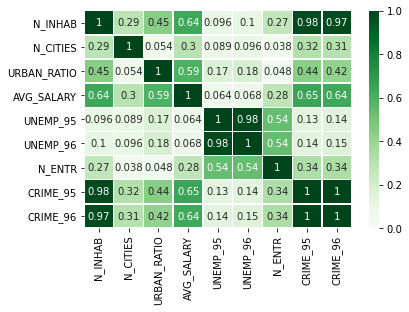

In [70]:
sns.heatmap(abs(dfDistrictsModel.corr()), vmin = 0, vmax = 1, cmap = "Greens", linewidths=0.5, annot=True)

It is observed that linear relationship between "UNEMP_95" and "UNEMP_96" are strong. That's why, a simple linear regression model can be used to predict missing value.

In [71]:
aX = np.array(dfDistrictsModel["UNEMP_96"]).reshape(-1,1)
aY = np.array(dfDistrictsModel["UNEMP_95"]).reshape(-1,1)

oLinRegModel = LinearRegression()

oLinRegModel.fit(aX, aY)

aUnemp95ToPredict = dfDistricts[dfDistricts["UNEMP_95"] == "?"].loc[:, "UNEMP_96"]
aUnemp95ToPredict = np.array(aUnemp95ToPredict).reshape(-1,1)

aUnemp95Predicted = oLinRegModel.predict(aUnemp95ToPredict)

There is a linear relationship between "CRIME_95", "CRIME_96" and "N_INHAB" fields. That's why, a simple linear regression model can be used to predict missing value.

In [72]:
aX = np.array(np.array(dfDistrictsModel[["CRIME_96", "N_INHAB"]]))
aY = np.array(dfDistrictsModel["CRIME_95"]).reshape(-1,1)

oLinRegModel = LinearRegression()

oLinRegModel.fit(aX, aY)

aCrime95ToPredict = dfDistricts[dfDistricts["CRIME_95"] == "?"].loc[:,["CRIME_96", "N_INHAB"]]
aCrime95ToPredict = np.array(aCrime95ToPredict)

aCrime95Predicted = oLinRegModel.predict(aCrime95ToPredict)

In order to replace question marks with predicted valeus,  missing rows are added back to dfDistrictsModel.

In [73]:
dfDistrictsModel= dfDistrictsModel.append(dfMissingRows)
dfDistrictsModel.sort_index(inplace=True)

Predicted valeus are added to missing rows.

In [74]:
dfMaskMissingUnemp95s = dfDistrictsModel["UNEMP_95"] == "?"
dfDistrictsModel.loc[dfMaskMissingUnemp95s,"UNEMP_95"] = aUnemp95Predicted

In [75]:
dfMaskMissingCrime95s = dfDistrictsModel["CRIME_95"] == "?"
dfDistrictsModel.loc[dfMaskMissingCrime95s,"CRIME_95"] = aCrime95Predicted

Now those columns can be converted to numerical type.

In [76]:
dfDistrictsModel["UNEMP_95"] = dfDistrictsModel["UNEMP_95"].astype(np.float64)
dfDistrictsModel["CRIME_95"] = dfDistrictsModel["CRIME_95"].astype(np.int64)

dfDistrictsModel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_INHAB      77 non-null     int64  
 1   N_CITIES     77 non-null     int64  
 2   URBAN_RATIO  77 non-null     float64
 3   AVG_SALARY   77 non-null     int64  
 4   UNEMP_95     77 non-null     float64
 5   UNEMP_96     77 non-null     float64
 6   N_ENTR       77 non-null     int64  
 7   CRIME_95     77 non-null     int64  
 8   CRIME_96     77 non-null     int64  
dtypes: float64(3), int64(6)
memory usage: 6.0 KB


### ACCOUNT_ID

There are 4915 rows that don't have value in "ACCOUNT_ID" field. This is not a big amount for this database. That's why, those rows are dropped from dfTransactionsModel.

In [77]:
dfMissingAccountIds = dfTransactionsModel[dfTransactionsModel["ACCOUNT_ID"].isna()]

In [78]:
dfMissingAccountIds

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
1190752,NaN,1993-01-30,300.0,300.0,CREDIT,CREDIT_IN_CASH
1132664,NaN,1993-02-06,4356.0,4656.0,CREDIT,COLLECTION_FROM_OTHER_BANK
711470,NaN,1993-02-19,500.0,500.0,CREDIT,CREDIT_IN_CASH
2524756,NaN,1993-03-28,600.0,600.0,CREDIT,CREDIT_IN_CASH
685667,NaN,1993-04-05,3247.0,6894.0,CREDIT,COLLECTION_FROM_OTHER_BANK
...,...,...,...,...,...,...
573665,NaN,1998-12-14,2080.0,48370.1,WITHDRAWAL,WITHDRAWAL_IN_CASH
823968,NaN,1998-12-14,2400.0,60471.9,WITHDRAWAL,WITHDRAWAL_IN_CASH
556532,NaN,1998-12-14,35859.0,89165.0,CREDIT,CREDIT_IN_CASH


In [79]:
dfTransactionsModel.drop(dfMissingAccountIds.index, inplace = True)

"ACCOUNT_ID" field is converted to integer format to be allign with dfCustomers's "ACCOINT_ID" field.

In [80]:
dfTransactionsModel["ACCOUNT_ID"] = dfTransactionsModel["ACCOUNT_ID"].astype(np.int64)

### OPERATION

In [81]:
dfTransactionsMissingOperation = dfTransactionsModel[dfTransactionsModel["OPERATION"].isna()]

In [82]:
dfTransactionsMissingOperation

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION
TRANS_ID,,,,,,
3602138,2177,1993-01-31,21.5,5944.5,CREDIT,NaN
3595783,1972,1993-01-31,19.1,5717.1,CREDIT,NaN
3594124,1926,1993-01-31,14.0,5221.0,CREDIT,NaN
3648651,3592,1993-01-31,19.5,6626.5,CREDIT,NaN
3645341,3487,1993-01-31,42.7,16756.7,CREDIT,NaN
...,...,...,...,...,...,...
3632826,3097,1998-12-31,43.7,10571.3,CREDIT,NaN
3630290,3017,1998-12-31,113.7,32446.6,CREDIT,NaN
3629757,2998,1998-12-31,184.7,47355.6,CREDIT,NaN


"TYPE" field of all of the missing values are "CREDIT". When all data is checked, "CREDIT" type can have 2 possible "OPERATION":

1. COLLECTION_FROM_OTHER_BANK
or
2. CREDIT_IN_CASH

In [83]:
dfTransactionsMissingOperation["TYPE"].unique()

array(['CREDIT'], dtype=object)

In [84]:
dfTransactionsModel[["TYPE", "OPERATION", "AMOUNT"]].groupby(["TYPE", "OPERATION"]).agg(["count", "min", "max"])

AMOUNT                 
                                        count     min      max
TYPE       OPERATION                                          
CREDIT     COLLECTION_FROM_OTHER_BANK   64243  2900.0  74812.0
           CREDIT_IN_CASH              154111   100.0  49999.0
WITHDRAWAL CC_WITHDRAWAL                 7858   100.0   8000.0
           REMITTANCE_TO_OTHER_BANK    205306     1.0  14882.0
           WITHDRAWAL_IN_CASH          427470     0.0  87400.0

A decision classifier can be used to predict missing "OPERATION" values. In order to train the classifier, it would be enough to use only the transactions that have "CREDIT" type. And "TYPE" field doesn't need to be an input feature since it is always same for all missing data.

In [85]:
dfTransactionsNonMissingOperation = dfTransactionsModel.drop(dfTransactionsMissingOperation.index)
dfTransactionsNonMissingOperation = dfTransactionsNonMissingOperation[dfTransactionsNonMissingOperation["TYPE"] == "CREDIT"]

In [86]:
dfX = dfTransactionsModel[dfTransactionsModel["TYPE"] == "CREDIT"].copy()

dfX.drop(["TYPE", "OPERATION", "DATE"], axis = 1, inplace=True)

dfX["TRANSACTION_YEAR"] = dfTransactionsModel["DATE"].dt.year
dfX["TRANSACTION_MONTH"] = dfTransactionsModel["DATE"].dt.month
dfX["TRANSACTION_DAY"] = dfTransactionsModel["DATE"].dt.day

In [87]:
dfX

,ACCOUNT_ID,AMOUNT,BALANCE,TRANSACTION_YEAR,TRANSACTION_MONTH,TRANSACTION_DAY
TRANS_ID,,,,,,
695247,2378,700.0,700.0,1993,1,1
171812,576,900.0,900.0,1993,1,1
207264,704,1000.0,1000.0,1993,1,1
1117247,3818,600.0,600.0,1993,1,1
579373,1972,400.0,400.0,1993,1,2
...,...,...,...,...,...,...
3632826,3097,43.7,10571.3,1998,12,31
3630290,3017,113.7,32446.6,1998,12,31
3629757,2998,184.7,47355.6,1998,12,31


In [88]:
dfY = pd.get_dummies(dfTransactionsModel[dfTransactionsModel["TYPE"] == "CREDIT"]["OPERATION"])

In [89]:
dfY

,COLLECTION_FROM_OTHER_BANK,CREDIT_IN_CASH
TRANS_ID,,
695247,0,1
171812,0,1
207264,0,1
1117247,0,1
579373,0,1
...,...,...
3632826,0,0
3630290,0,0
3629757,0,0


In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    dfX.loc[dfTransactionsNonMissingOperation.index], 
    dfY.loc[dfTransactionsNonMissingOperation.index], 
    test_size=0.3, 
    random_state=1, 
    shuffle=True)

In [91]:
oDecTreeModel =  DecisionTreeClassifier()
oDecTreeModel.fit(X_train, y_train)

y_pred = oDecTreeModel.predict(X_test)

y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = y_test.columns )

Both classes have good accuracy and f1 score meaning that decision tree model may able to predict both True Positives and True Negatives.

In [92]:
print(classification_report(y_test, y_pred, target_names=dfY.columns))

for sClass in dfY.columns:
    print(f"Accuracy of : " + sClass + ": "+ str(round(metrics.accuracy_score(y_test[sClass], y_pred[sClass]), 2))) 

                            precision    recall  f1-score   support

COLLECTION_FROM_OTHER_BANK       0.95      0.97      0.96     19259
            CREDIT_IN_CASH       0.99      0.98      0.98     46248

                 micro avg       0.98      0.98      0.98     65507
                 macro avg       0.97      0.97      0.97     65507
              weighted avg       0.98      0.98      0.98     65507
               samples avg       0.98      0.98      0.98     65507

Accuracy of : COLLECTION_FROM_OTHER_BANK: 0.98
Accuracy of : CREDIT_IN_CASH: 0.98


All of the missing values are predicted as "CREDIT_IN_CASH" value.

In [93]:
aPredictionsForMissingOperations = oDecTreeModel.predict(dfX.loc[dfTransactionsMissingOperation.index])
dfPredictionsForMissingOperations = pd.DataFrame(data = aPredictionsForMissingOperations, columns = dfY.columns, index = dfTransactionsMissingOperation.index)

aPredictedOperations = dfPredictionsForMissingOperations.idxmax(axis=1)

dfTransactionsModel.loc[dfTransactionsMissingOperation.index,"OPERATION"] = aPredictedOperations

In [94]:
aPredictedOperations.unique()

array(['CREDIT_IN_CASH'], dtype=object)

## Merging Datasets

In [95]:
dfDataAnalysis = dfTransactionsModel.reset_index().merge(dfCustomersModel.reset_index(), on = "ACCOUNT_ID", how = "inner").set_index("TRANS_ID")

There are transactions where "ACCOUNT_ID" are not in dfCustomers.

In [96]:
len(dfTransactionsModel) - len(dfDataAnalysis)

11909

There are no customer who doesn't have any transaction.

In [97]:
len(dfDataAnalysis["CLIENT_ID"].unique()) - len(dfCustomersModel)

0

In [98]:
dfDataAnalysis = dfDataAnalysis.reset_index().merge(dfDistrictsModel.reset_index(), on = "DISTRICT_ID", how = "inner").set_index("TRANS_ID")

There are customers from each district.

In [99]:
len(dfCustomersModel["DISTRICT_ID"].unique()) - len(dfDistrictsModel)

0

### CUSTOMER_AGE

Customer age on transaction date is calculated. "BIRTH_DT" field is dropped.

In [110]:
dfDataAnalysis["CUSTOMER_AGE"] = dfDataAnalysis["DATE"].dt.year - dfDataAnalysis["BIRTH_DT"].dt.year

In [113]:
np.sort(dfDataAnalysis["CUSTOMER_AGE"].unique())

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80], dtype=int64)

In [118]:
dfDataAnalysis.drop("BIRTH_DT", axis = 1, inplace = True)

In [119]:
dfDataAnalysis.head()

,ACCOUNT_ID,DATE,AMOUNT,BALANCE,TYPE,OPERATION,CLIENT_ID,GENDER,ACTIVE,LOAN,...,N_INHAB,N_CITIES,URBAN_RATIO,AVG_SALARY,UNEMP_95,UNEMP_96,N_ENTR,CRIME_95,CRIME_96,CUSTOMER_AGE
TRANS_ID,,,,,,,,,,,,,,,,,,,,,
695247,2378,1993-01-01,700.0,700.0,CREDIT,CREDIT_IN_CASH,2873,F,1,0.0,...,93931,8,56.9,8427,1.12,1.54,107,1874,1913,18
695250,2378,1993-01-22,7268.0,7968.0,CREDIT,CREDIT_IN_CASH,2873,F,1,0.0,...,93931,8,56.9,8427,1.12,1.54,107,1874,1913,18
695266,2378,1993-01-23,14440.0,22408.0,CREDIT,CREDIT_IN_CASH,2873,F,1,0.0,...,93931,8,56.9,8427,1.12,1.54,107,1874,1913,18
695262,2378,1993-01-24,49752.0,72160.0,CREDIT,CREDIT_IN_CASH,2873,F,1,0.0,...,93931,8,56.9,8427,1.12,1.54,107,1874,1913,18
695265,2378,1993-01-26,21899.0,94059.0,CREDIT,CREDIT_IN_CASH,2873,F,1,0.0,...,93931,8,56.9,8427,1.12,1.54,107,1874,1913,18


In [120]:
dfDataAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027026 entries, 695247 to 3583259
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   ACCOUNT_ID    1027026 non-null  int64         
 1   DATE          1027026 non-null  datetime64[ns]
 2   AMOUNT        1027026 non-null  float64       
 3   BALANCE       1027026 non-null  float64       
 4   TYPE          1027026 non-null  object        
 5   OPERATION     1027026 non-null  object        
 6   CLIENT_ID     1027026 non-null  int64         
 7   GENDER        1027026 non-null  object        
 8   ACTIVE        1027026 non-null  int64         
 9   LOAN          1027026 non-null  float64       
 10  DISTRICT_ID   1027026 non-null  int64         
 11  SET_SPLIT     1027026 non-null  object        
 12  N_INHAB       1027026 non-null  int64         
 13  N_CITIES      1027026 non-null  int64         
 14  URBAN_RATIO   1027026 non-null  float64      

# DATA ANALYSIS

## ANALYSIS #1

In [135]:
dfAnalysis1 = dfDataAnalysis[["DATE", "AMOUNT"]].groupby(["DATE"], as_index = False).agg(["count", "mean"])["AMOUNT"].reset_index()

Looks like there is a seasonality in average amount of payment. Looks like average payment doesn't change after 1994. But there is a high deviation on average payment in 1993. On every January, average payment goes down.

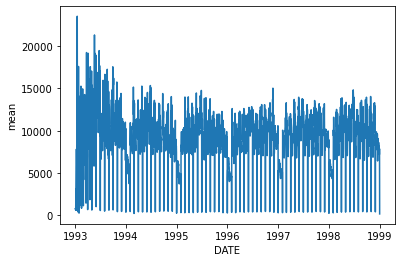

In [174]:
sns.lineplot(data = dfAnalysis1 , x= "DATE",  y = "mean")

At the end of each month number of payment increases.

In [166]:
px.line(dfAnalysis1, x='DATE', y="count").show()